In [1]:
import pandas as pd
import requests
import os
import ast  # Add this import

In [2]:
# URLs of the CSV files
url_recipes = 'https://raw-recipes-clean-upgrad.s3.amazonaws.com/RAW_recipes_cleaned.csv'
url_interactions = 'https://raw-interactions-upgrad.s3.amazonaws.com/RAW_interactions_cleaned.csv'

In [3]:
# Function to download and save CSV files
def download_csv(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

In [4]:
# Download the CSV files
download_csv(url_recipes, 'RAW_recipes_cleaned.csv')
download_csv(url_interactions, 'RAW_interactions_cleaned.csv')

In [5]:
# Check if the file is downloaded completely
print(f"Size of RAW_recipes_cleaned.csv: {os.path.getsize('RAW_recipes_cleaned.csv')} bytes")
print(f"Size of RAW_interactions_cleaned.csv: {os.path.getsize('RAW_interactions_cleaned.csv')} bytes")

Size of RAW_recipes_cleaned.csv: 293745763 bytes
Size of RAW_interactions_cleaned.csv: 346524039 bytes


In [13]:
# Read the CSV files with additional parameters to handle potential issues
recipes_df = pd.read_csv('RAW_recipes_cleaned.csv', sep=',', engine='python', on_bad_lines='skip')
interactions_df = pd.read_csv('RAW_interactions_cleaned.csv', sep=',', engine='python', on_bad_lines='skip')

print("Recipes Data Loaded:")
print(recipes_df.head())

print("\nInteractions Data Loaded:")
print(interactions_df.head())

Recipes Data Loaded:
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition 

In [14]:
import ast

# Function to safely evaluate the nutrition column
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

In [15]:
# Convert the nutrition column from a string to a list
recipes_df['nutrition'] = recipes_df['nutrition'].apply(safe_literal_eval)

In [16]:
# Filter out any rows where the nutrition column is not a list of 7 elements
recipes_df = recipes_df[recipes_df['nutrition'].apply(lambda x: isinstance(x, list) and len(x) == 7)]

In [17]:
# Create individual columns for each nutrition value
nutrition_columns = ['calories', 'total_fat_PDV', 'sugar_PDV', 'sodium_PDV', 'protein_PDV', 'saturated_fat_PDV', 'carbohydrates_PDV']
nutrition_df = pd.DataFrame(recipes_df['nutrition'].tolist(), columns=nutrition_columns)

In [18]:
# Concatenate the new columns to the original DataFrame
recipes_df = pd.concat([recipes_df, nutrition_df], axis=1)
recipes_df.drop('nutrition', axis=1, inplace=True)

print("Individual Nutrition Features Extracted:")
print(recipes_df[nutrition_columns].head())

Individual Nutrition Features Extracted:
   calories  total_fat_PDV  sugar_PDV  sodium_PDV  protein_PDV  \
0      51.5            0.0       13.0         0.0          2.0   
1     173.4           18.0        0.0        17.0         22.0   
2     269.8           22.0       32.0        48.0         39.0   
3     368.1           17.0       10.0         2.0         14.0   
4     352.9            1.0      337.0        23.0          3.0   

   saturated_fat_PDV  carbohydrates_PDV  
0                0.0                4.0  
1               35.0                1.0  
2               27.0                5.0  
3                8.0               20.0  
4                0.0               28.0  


In [20]:
# Standardize the nutritional values to per 100 calories
def standardize_nutrition(nutrition_list):
    calories = nutrition_list[0]
    if calories == 0:  # Avoid division by zero
        return nutrition_list
    return [value * 100 / calories for value in nutrition_list]

# Apply standardization to each nutritional value column
for col in nutrition_columns:
    recipes_df[col] = recipes_df[nutrition_columns].apply(lambda row: row[col] * 100 / row['calories'], axis=1)

print("\nNutrition Values Standardized (per 100 calories):")
print(recipes_df[nutrition_columns].head())

C:\Users\tusha\AppData\Local\Temp\ipykernel_13840\2814278042.py:10: RuntimeWarning: invalid value encountered in scalar divide
  recipes_df[col] = recipes_df[nutrition_columns].apply(lambda row: row[col] * 100 / row['calories'], axis=1)



Nutrition Values Standardized (per 100 calories):
   calories  total_fat_PDV  sugar_PDV  sodium_PDV  protein_PDV  \
0     100.0            0.0       13.0         0.0          2.0   
1     100.0           18.0        0.0        17.0         22.0   
2     100.0           22.0       32.0        48.0         39.0   
3     100.0           17.0       10.0         2.0         14.0   
4     100.0            1.0      337.0        23.0          3.0   

   saturated_fat_PDV  carbohydrates_PDV  
0                0.0                4.0  
1               35.0                1.0  
2               27.0                5.0  
3                8.0               20.0  
4                0.0               28.0  


In [21]:
# Convert the tags column from a string to an array of strings
recipes_df['tags'] = recipes_df['tags'].apply(ast.literal_eval)
print("\nTags Converted to Array of Strings:")
print(recipes_df[['tags']].head())


Tags Converted to Array of Strings:
                                                tags
0  [60-minutes-or-less, time-to-make, course, mai...
1  [30-minutes-or-less, time-to-make, course, mai...
2  [time-to-make, course, preparation, main-dish,...
3  [60-minutes-or-less, time-to-make, course, mai...
4  [weeknight, time-to-make, course, main-ingredi...


In [22]:
# Join the interaction data with the recipe data
combined_df = pd.merge(interactions_df, recipes_df, left_on='recipe_id', right_on='id')
print("\nData Combined:")
print(combined_df.head())


Data Combined:
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  \
0  Great with a salad. Cooked on top of stove for...   
1  So simple  so delicious! Great for chilly fall...   
2  This worked very well and is EASY.  I used not...   
3  I made the Mexican topping and took it to bunk...   
4  Made the cheddar bacon topping  adding a sprin...   

                                   name     id  minutes  contributor_id  \
0  white bean   green chile pepper soup  40893      495            1533   
1  white bean   green chile pepper soup  40893      495            1533   
2      devilicious cookie cake delights  44394       20           56824   
3                 baked potato toppings  85009       10           64342   
4

In [23]:
# Create features capturing the time difference between review date and submission date
combined_df['submitted'] = pd.to_datetime(combined_df['submitted'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

combined_df['days_between'] = (combined_df['date'] - combined_df['submitted']).dt.days
print("\nTime-based Feature 'days_between' Created:")
print(combined_df[['submitted', 'date', 'days_between']].head())


Time-based Feature 'days_between' Created:
   submitted       date  days_between
0 2002-09-21 2003-02-17           149
1 2002-09-21 2011-12-21          3378
2 2002-10-27 2002-12-01            35
3 2004-02-25 2010-02-27          2194
4 2004-02-25 2011-10-01          2775


In [24]:
# Save the combined data
combined_df.to_csv('combined_data.csv', index=False)
print("Combined data saved to 'combined_data.csv'.")

Combined data saved to 'combined_data.csv'.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined data
combined_df = pd.read_csv('combined_data.csv')

In [26]:
# Basic statistics
print(combined_df.describe())

            user_id     recipe_id        rating            id       minutes  \
count  1.132367e+06  1.132367e+06  1.132367e+06  1.132367e+06  1.132367e+06   
mean   1.384291e+08  1.608972e+05  4.411016e+00  1.608972e+05  3.614684e+04   
std    5.014269e+08  1.303987e+05  1.264752e+00  1.303987e+05  8.796494e+06   
min    1.533000e+03  3.800000e+01  0.000000e+00  3.800000e+01  0.000000e+00   
25%    1.354700e+05  5.425700e+04  4.000000e+00  5.425700e+04  2.000000e+01   
50%    3.309370e+05  1.205470e+05  5.000000e+00  1.205470e+05  4.000000e+01   
75%    8.045500e+05  2.438520e+05  5.000000e+00  2.438520e+05  7.000000e+01   
max    2.002373e+09  5.377160e+05  5.000000e+00  5.377160e+05  2.147484e+09   

       contributor_id       n_steps  n_ingredients   calories  total_fat_PDV  \
count    1.132367e+06  1.132367e+06   1.132367e+06  1132132.0   1.132132e+06   
mean     2.655967e+06  9.627970e+00   8.952028e+00      100.0   3.465003e+01   
std      6.774670e+07  5.819689e+00   3.689908e+

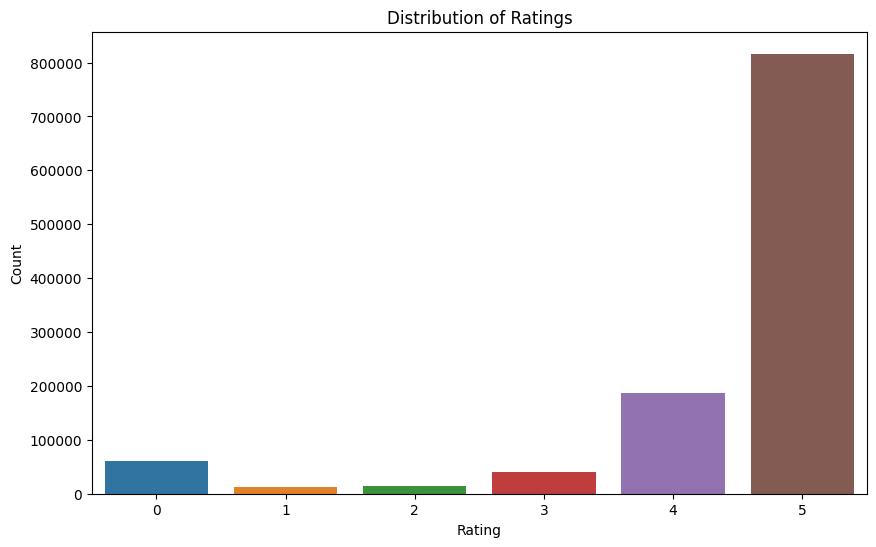

In [27]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=combined_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

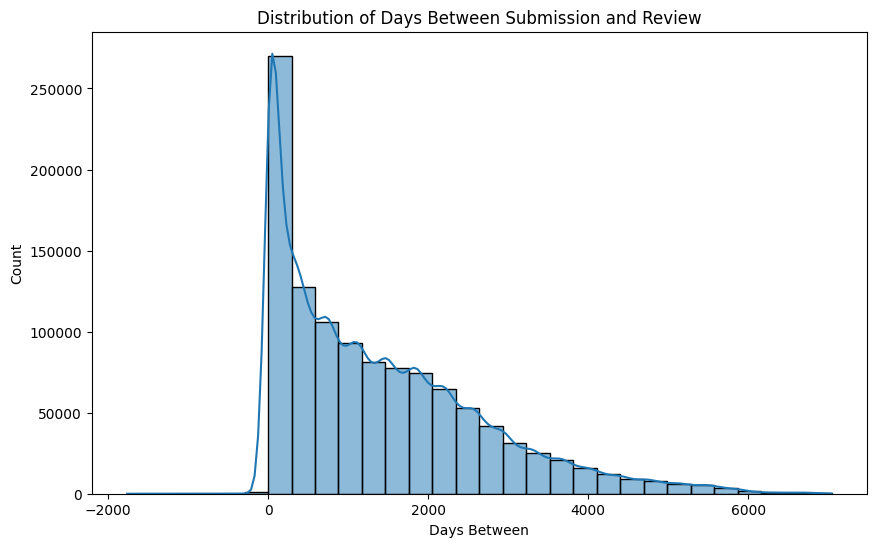

In [28]:
# Distribution of days between submission and review
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['days_between'], bins=30, kde=True)
plt.title('Distribution of Days Between Submission and Review')
plt.xlabel('Days Between')
plt.ylabel('Count')
plt.show()

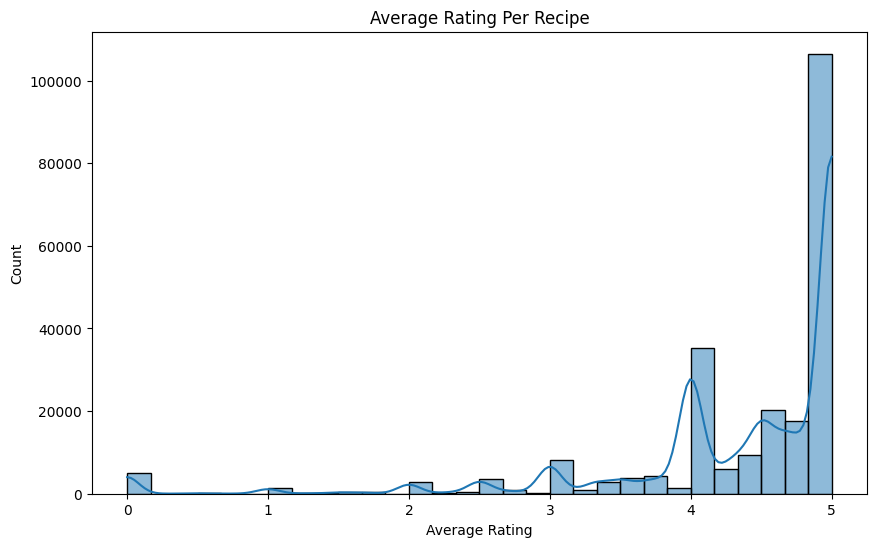

In [29]:
# Average rating per recipe
avg_rating_per_recipe = combined_df.groupby('recipe_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_recipe, bins=30, kde=True)
plt.title('Average Rating Per Recipe')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

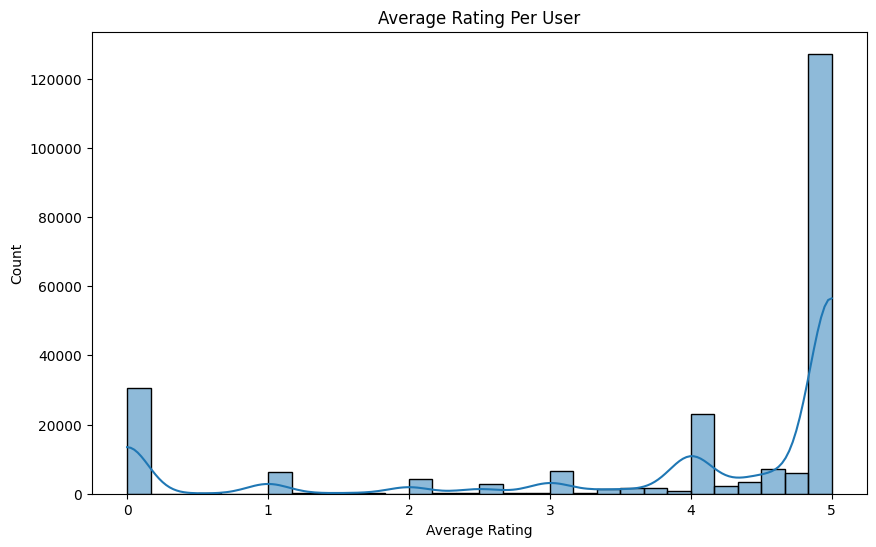

In [30]:
# Average rating per user
avg_rating_per_user = combined_df.groupby('user_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_user, bins=30, kde=True)
plt.title('Average Rating Per User')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

In [31]:
import pandas as pd

# Load the combined data
combined_df = pd.read_csv('combined_data.csv')

In [32]:

# Create user-level features
user_features = combined_df.groupby('user_id').agg(
    user_avg_rating=('rating', 'mean'),
    user_rating_count=('rating', 'count'),
    user_avg_days_between=('days_between', 'mean')
).reset_index()

print("User-level Features Created:")
print(user_features.head())

User-level Features Created:
   user_id  user_avg_rating  user_rating_count  user_avg_days_between
0     1533         4.710938                128             361.921875
1     1535         4.473552                794            1183.507557
2     1581         5.000000                  1            1804.000000
3     1634         3.616667                 60             249.033333
4     1676         4.677419                 31            1287.935484


In [33]:
# Create recipe-level features
recipe_features = combined_df.groupby('recipe_id').agg(
    recipe_avg_rating=('rating', 'mean'),
    recipe_rating_count=('rating', 'count'),
    recipe_avg_days_between=('days_between', 'mean')
).reset_index()

print("Recipe-level Features Created:")
print(recipe_features.head())

Recipe-level Features Created:
   recipe_id  recipe_avg_rating  recipe_rating_count  recipe_avg_days_between
0         38           4.250000                    4              4375.500000
1         39           3.000000                    1              2701.000000
2         40           4.333333                    9              2308.888889
3         41           4.500000                    2              2375.500000
4         43           1.000000                    1              3458.000000


In [34]:
# Merge user and recipe features back to the combined DataFrame
combined_df = combined_df.merge(user_features, on='user_id', how='left')
combined_df = combined_df.merge(recipe_features, on='recipe_id', how='left')

print("Combined Data with User and Recipe Features:")
print(combined_df.head())

Combined Data with User and Recipe Features:
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  \
0  Great with a salad. Cooked on top of stove for...   
1  So simple  so delicious! Great for chilly fall...   
2  This worked very well and is EASY.  I used not...   
3  I made the Mexican topping and took it to bunk...   
4  Made the cheddar bacon topping  adding a sprin...   

                                   name     id  minutes  contributor_id  \
0  white bean   green chile pepper soup  40893      495            1533   
1  white bean   green chile pepper soup  40893      495            1533   
2      devilicious cookie cake delights  44394       20           56824   
3                 baked potato toppings  85009 

In [35]:
# Save the enhanced combined DataFrame for model building
combined_df.to_csv('enhanced_combined_data.csv', index=False)
print("Enhanced combined data saved to 'enhanced_combined_data.csv'.")

Enhanced combined data saved to 'enhanced_combined_data.csv'.
